# Modèle sur mesure avancé

### Sommaire
1. [Encodage des données textuelles à l'aide du tokenizer BERT](#paragraph1)</p> 
2. [Entrainement du modèle Bert](#paragraph2)</p>
3. [Mettre à jour un modèle BERT avec les poids entraînés](#paragraph3)</p>

In [34]:
import sys
sys.path.append('../src')  # Add the src folder to the module search path
from utils import Utils

import os
# Maths modules
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# precision, recall, f1-score,
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score

# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

# Tokenizers, Stemmers and Lemmatizers
import nltk
from nltk.corpus import stopwords
import spacy
# Download resources
nltk.download("stopwords")
stopwords = set(stopwords.words("english"))
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, Embedding, Bidirectional
from tensorflow.keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\doly9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\doly9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df = pd.read_csv('D:/openclassroom/projet7/input/df_cleaned_docs.csv',encoding='ISO-8859-1')

In [19]:
df.head()

,target,text,clean_text
0,NEGATIVE,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot httptwitpiccom awww s bummer should...
1,NEGATIVE,is upset that he can't update his Facebook by ...,upset not update facebook texte cry result sch...
2,NEGATIVE,@Kenichan I dived many times for the ball. Man...,kenichan dive time ball manage save rest bound
3,NEGATIVE,my whole body feels itchy and like its on fire,body feel itchy like fire
4,NEGATIVE,"@nationwideclass no, it's not behaving at all....",nationwideclass behave m mad not


In [20]:
sampled_data = df.sample(n=1000000, random_state=42)

## 1. Encodage des données textuelles à l'aide du tokenizer BERT<a class="anchor" id="paragraph1"></a>

In [5]:
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

C:\Users\doly9\Anaconda3\envs\envproject7\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\doly9\Anaconda3\envs\envproject7\lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
C:\Users\doly9\Anaconda3\envs\envproject7\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\doly9\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be di

In [6]:
#Load the sentences into the BERT Tokenizer.

In [11]:
input_ids=[]
attention_masks=[]
sentences = sampled_data['clean_text']
for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =50,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=sampled_data['target'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\doly9\Anaconda3\envs\envproject7\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
#Saving and loading the data into the pickle files
import pickle
results_data_path = os.path.join("..", "outputs")
pickle_inp_path=os.path.join(results_data_path,'bert_inp.pkl')
pickle_mask_path=os.path.join(results_data_path,'bert_mask.pkl')
pickle_label_path=os.path.join(results_data_path,'bert_label.pkl')

In [13]:

print('Preparing the pickle file.....')
pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((np.array(labels)),open(pickle_label_path,'wb'))

print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Preparing the pickle file.....
Pickle files saved as  ..\outputs\bert_inp.pkl ..\outputs\bert_mask.pkl ..\outputs\bert_label.pkl


In [21]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Loading the saved pickle files..
Input shape (1000000, 50) Attention mask shape (1000000, 50) Input label shape (1000000,)


In [53]:
#Spitting into train and validation set

In [22]:
train_inp,test_inp,train_label,test_label,train_mask,test_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2,random_state=42)
val_inp, test_inp, val_label, test_label, val_mask, test_mask = train_test_split(test_inp,test_label,test_mask, test_size=0.33, random_state=42)

# Vérifier la taille des jeux de données
print("Taille du jeu d'entraînement :", train_inp.shape)
print("Taille du jeu de validation :", val_inp.shape)
print("Taille du jeu de test :", test_inp.shape)

Taille du jeu d'entraînement : (800000, 50)
Taille du jeu de validation : (134000, 50)
Taille du jeu de test : (66000, 50)


## 2. Entrainement du modèle Bert <a class="anchor" id="paragraph2"></a>

In [23]:
print('\nBert Model',bert_model.summary())

bert_model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=2e-5), metrics=BinaryAccuracy())

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [35]:
checkpoint_callback = ModelCheckpoint(filepath=os.path.join("..", "saved_models/bert")+'/'+'_epoch_{epoch:02d}.h5', 
                                      save_freq=1, save_weights_only=True)
tensorboard_callback = TensorBoard(log_dir=os.path.join("..", "logs")+'/bert')
callbacks=[checkpoint_callback,tensorboard_callback]

history=bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=5,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)


Epoch 1/5
  133/25000 [..............................] - ETA: 35:06:19 - loss: 0.7706 - binary_accuracy: 0.5740

KeyboardInterrupt: 

In [22]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

history=bert_model.fit([train_inp,train_mask],train_label,batch_size=64,epochs=10,
                       validation_data=([val_inp,val_mask],val_label),
                        workers=4,
                        use_multiprocessing=True,)


Epoch 1/10
  270/19969 [..............................] - ETA: 1353:25:10 - loss: 0.6683 - binary_accuracy: 0.6398

KeyboardInterrupt: 

## 3.Mettre à jour un modèle BERT avec les poids entraînés<a class="anchor" id="paragraph3"></a>

In [24]:
# Load the trained weights from the .h5 file
bert_model.load_weights(os.path.join("..", "saved_models",'bert_weights.h5'))

# Compile the model
bert_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(curve="ROC", name="ROC_AUC")])

In [ ]:
y_train_pred_proba = bert_model.predict([train_inp,train_mask])

 7188/25000 [=======>......................] - ETA: 5:29:43

In [25]:
y_pred_proba = bert_model.predict([test_inp,test_mask])

2063/2063 [==============================] - 1959s 947ms/step


In [26]:
y_pred_proba

TFSequenceClassifierOutput(loss=None, logits=array([[0.93472844, 0.86206394],
       [0.10232023, 0.09827419],
       [0.35728437, 0.33339134],
       ...,
       [0.6686935 , 0.63677424],
       [0.16889217, 0.15504488],
       [0.6481481 , 0.6150536 ]], dtype=float32), hidden_states=None, attentions=None)

In [29]:
y_pred = np.argmax(y_pred_proba[0], axis=1)  # Get the class with the highest probability

y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [31]:
cf = confusion_matrix(test_label, y_pred)
cf

array([[26990,  6127],
       [32712,   171]], dtype=int64)

In [38]:
acc_train = accuracy_score(y_true=test_label, y_pred=y_pred)
acc_train

0.411530303030303

In [ ]:
    acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    acc_valid = accuracy_score(y_true=y_valid, y_pred=y_valid_pred)
    y_train_pred_proba = LR_model.predict_proba(X_train)[::,1]
    y_valid_pred_proba = LR_model.predict_proba(X_test)[::,1]
    roc_train = roc_auc_score(y_train, y_train_pred_proba)
    roc_valid = roc_auc_score(y_valid, y_valid_pred_proba)

NameError: name 'y' is not defined

<Figure size 640x480 with 0 Axes>

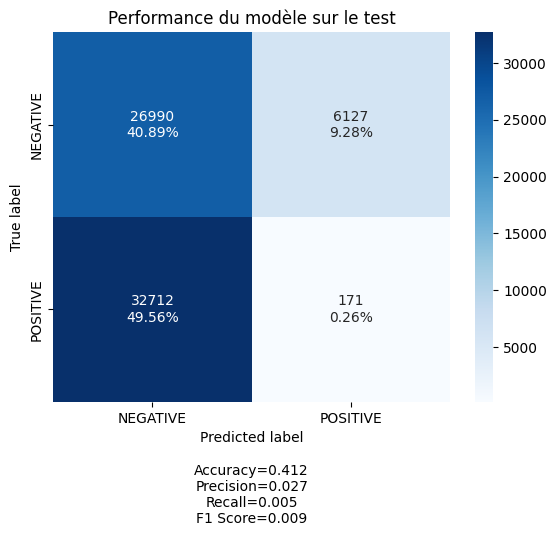

<Figure size 640x480 with 0 Axes>

In [37]:
plt.figure()
Utils.make_confusion_matrix(cf, categories=['NEGATIVE', 'POSITIVE'], title="Performance du modèle sur le "+"test")
plt.figure()
Utils.plot_roc_curve(y_pred_proba,y,title='Courbe ROC sur le ' + "test")

## 4. Gestion des expérimentations des modèles avec MLFlow<a class="anchor" id="paragraph4"></a>

In [ ]:
import mlflow.keras as mlk
class BertModel():
    def __init__(self):
        # Load the trained weights from the .h5 file
        self.bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
        self.bert_model = load_weights(os.path.join("..", "saved_models",'bert_weights.h5'))
    def build(self):
        self.bert_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(curve="ROC", name="ROC_AUC")])
    def mlflow_run(self, epochs, batch_size):
        with mlflow.start_run(run_name=self.name_model) as run:
            # Automatically capture the model's parameters, metrics, artifacts,
            # and source code with the autolog() function
            mlk.autolog()
            # Enregistrez les paramètres
            mlflow.log_param("units_lstm", self.units_lstm)
            mlflow.log_param("units_dense", self.units_dense)
            self.bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=5,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)
        return run.info.run_id

In [ ]:
import mlflow

if __name__ == "__main__":
    
    mlflow.set_experiment(experiment_name = "p7-advanced model")
    mlflow.autolog()
    # Use sqlite:///mlruns.db as the local store for tracking and registery
    mlflow.set_tracking_uri("sqlite:///mlruns.db")

    name_model = "glove_bilstm"
    type_model ="BidirectionalLSTM"
    units_lstm = 100
    units_dense = 20
    opt = "adam"
    epoch = 30
    batch_size = 1024

    model = AdvancedModel(name_model,type_model,word2vec_layer,units_lstm,units_dense, X_train, y_train)
    model.build()
    run_id = model.mlflow_run(epoch,batch_size)
    print("MLflow run_id={}".format(run_id))
